# Machine Learning for Climate Change Final Project

In [ ]:
# Import all the needed libraries as well as set up API

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('912dec1ed8b140b7818f4da976962d83')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
import datetime
tqdm.pandas()

In [ ]:
# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Getting the Data from the Microsoft Planetary Computer API

In [ ]:
# load in the data
crop_presence_data = pd.read_csv("Crop_Location_Data.csv")

In [ ]:
# Method to load the data
def get_sentinel_data(latlong, time_slice):
    try:
        box_size_deg = 0.0004
        latlong = latlong.replace('(','').replace(')','').replace(' ','').split(',')
        bbox_of_interest = (float(latlong[1])-box_size_deg/2, float(latlong[0])-box_size_deg/2, float(latlong[1])+box_size_deg/2, float(latlong[0])+box_size_deg/2)
        time_of_interest = time_slice

        catalog = pystac_client.Client.open(
            "https://planetarycomputer.microsoft.com/api/stac/v1"
        )
        search = catalog.search(
            collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
        )
        items = list(search.get_all_items())

        vh_values = []
        vv_values = []
        datetimes = []
        resolution = 10
        scale = resolution / 111320.0
        for item in items:
            data = stac_load([item], patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326", resolution=scale).isel(time=0)
            vh_values.append(data["vh"].astype("float").values.tolist()[0][0])
            vv_values.append(data["vv"].astype("float").values.tolist()[0][0])
            datetimes.append(datetime.datetime.strptime(item.properties['datetime'], '%Y-%m-%dT%H:%M:%S.%fZ'))

        VH = np.array(vh_values)
        VV = np.array(vv_values)
        dates = np.array(datetimes)
        dop = (VV / (VV + VH))
        RVI = (np.sqrt(dop))*((4*VH)/(VV + VH))
        return RVI, VH, VV, dates
    except:
        return np.array([]), np.array([]), np.array([]), np.array([])

In [ ]:
# This gets rvi, vv, and vh values between December and May. Don't run this it was just used to get the data 
# Sentinel-1 the first time. Takes ~1 Hour to run. 
rvi_list = []
lengths = []
vv_list = []
vh_list = []
date_list = []
start_date = datetime.datetime(2021, 12, 1)
end_date = datetime.datetime(2022, 5, 1)
time_slice = f"{start_date.date().isoformat()}/{end_date.date().isoformat()}"
for latlong in tqdm(crop_presence_data['Latitude and Longitude']):
    RVI, VH, VV, dates = get_sentinel_data(latlong, time_slice)
    date_list.append(dates)
    rvi_list.append(RVI)
    vh_list.append(VH)
    vv_list.append(VV)
    lengths.append(len(RVI))
    if len(RVI) == 0:
        print("API Failed")


RVI

In [ ]:
# Adds the lists to the dataframe as different columns 
crop_presence_data['rvi_list'] = rvi_list_np
crop_presence_data['lengths'] = lengths_np
crop_presence_data['vv_list'] = vv_list_np
crop_presence_data['vh_list'] = vh_list_np
crop_presence_data['date_list'] = date_list_np

In [ ]:
# Stores data for later
crop_presence_data.to_csv('crop_presence_data.csv', index=False)

# Processing

In [ ]:
# Reads the stored data
# but numpy arrays have been transformed into strings
crop_presence_data_rvi = pd.read_csv("crop_presence_data.csv")
crop_presence_data_rvi

,Latitude and Longitude,Class of Land,rvi_list,lengths,vv_list,vh_list,date_list
0,"(10.323727047081501, 105.2516346045924)",Rice,[0.24121406 0.11737315 0.87943922 0.56445609 0...,27,[0.20333965 0.24376777 0.04290899 0.1177595 0...,[0.01350363 0.00748491 0.01466113 0.02133146 0...,"[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
1,"(10.322364360592521, 105.27843410554115)",Rice,[0.10417547 0.1437641 1.08172944 0.42283536 0...,27,[0.38207614 0.66017032 0.01080536 0.02471643 0...,[0.01035812 0.02509276 0.00533438 0.00312332 0...,"[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
2,"(10.321455902933202, 105.25254306225168)",Rice,[0.12641419 0.07017864 1.46733812 0.28291069 0...,27,[0.16689092 0.23854624 0.0043432 0.05102119 0...,[0.00553909 0.00429885 0.00514218 0.00404629 0...,"[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
3,"(10.324181275911162, 105.25118037576274)",Rice,[0.16640069 0.06401261 0.12882467 0.42438946 0...,27,[0.09989987 0.48853126 0.20916232 0.08050094 0...,[0.00443569 0.00801113 0.00708129 0.01021758 0...,"[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
4,"(10.324635504740822, 105.27389181724476)",Rice,[0.25972569 0.50493937 0.57290832 0.25385513 0...,27,[0.23766939 0.19733885 0.09877711 0.09765452 0...,[0.01713037 0.03100726 0.01824253 0.00686211 0...,"[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
...,...,...,...,...,...,...,...
595,"(10.013942985253381, 105.67361318732796)",Non Rice,[0.87951507 0.56007 1.23079434 1.51891794 0...,27,[0.16439259 0.17760225 0.09281 0.0726037 0...,[0.05617744 0.03184774 0.06081853 0.10965218 0...,"[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
596,"(10.01348875642372, 105.67361318732796)",Non Rice,[0.79734873 0.87573529 0.85049155 0.87609831 0...,27,[0.18009475 0.32515299 0.22422008 0.3623648 0...,[0.05278958 0.11034318 0.07262009 0.12305354 0...,"[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
597,"(10.013034527594062, 105.67361318732796)",Non Rice,[0.56580631 1.06861499 0.92877044 0.58257124 0...,27,[0.20298794 0.228407 0.11824816 0.2461282 0...,[0.03688442 0.11008551 0.04421739 0.04646202 0...,"[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
598,"(10.012580298764401, 105.67361318732796)",Non Rice,[0.95931384 0.62005908 0.55911379 0.74726399 0...,27,[0.22476733 0.43389046 0.48923901 0.27300829 0...,[0.08884174 0.08897499 0.08753669 0.0726649 0...,"[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."


In [ ]:
# Define function to turn all of the strings in pandas dataframe into numpy arrays
def str_to_np(string):
    string = string[1:-1]  # remove brackets
    arr = np.fromstring(string, sep=' ')
    return arr

In [ ]:
# Turn data back into original datatypes
crop_presence_data_rvi['rvi_list'] = crop_presence_data_rvi['rvi_list'].apply(str_to_np)
crop_presence_data_rvi['vv_list'] = crop_presence_data_rvi['vv_list'].apply(str_to_np)
crop_presence_data_rvi['vh_list'] = crop_presence_data_rvi['vh_list'].apply(str_to_np)
crop_presence_data_rvi['lengths'] = crop_presence_data_rvi['lengths'].astype(int)

In [ ]:
# One Hot Encode Non Rice and Rice to 0 and 1
crop_presence_data_rvi['Class of Land'] = crop_presence_data_rvi['Class of Land'].replace({'Non Rice': 0, 'Rice': 1})
crop_presence_data_rvi

,Latitude and Longitude,Class of Land,rvi_list,lengths,vv_list,vh_list,date_list
0,"(10.323727047081501, 105.2516346045924)",1,"[0.24121406, 0.11737315, 0.87943922, 0.5644560...",27,"[0.20333965, 0.24376777, 0.04290899, 0.1177595...","[0.01350363, 0.00748491, 0.01466113, 0.0213314...","[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
1,"(10.322364360592521, 105.27843410554115)",1,"[0.10417547, 0.1437641, 1.08172944, 0.42283536...",27,"[0.38207614, 0.66017032, 0.01080536, 0.0247164...","[0.01035812, 0.02509276, 0.00533438, 0.0031233...","[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
2,"(10.321455902933202, 105.25254306225168)",1,"[0.12641419, 0.07017864, 1.46733812, 0.2829106...",27,"[0.16689092, 0.23854624, 0.0043432, 0.05102119...","[0.00553909, 0.00429885, 0.00514218, 0.0040462...","[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
3,"(10.324181275911162, 105.25118037576274)",1,"[0.16640069, 0.06401261, 0.12882467, 0.4243894...",27,"[0.09989987, 0.48853126, 0.20916232, 0.0805009...","[0.00443569, 0.00801113, 0.00708129, 0.0102175...","[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
4,"(10.324635504740822, 105.27389181724476)",1,"[0.25972569, 0.50493937, 0.57290832, 0.2538551...",27,"[0.23766939, 0.19733885, 0.09877711, 0.0976545...","[0.01713037, 0.03100726, 0.01824253, 0.0068621...","[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
...,...,...,...,...,...,...,...
595,"(10.013942985253381, 105.67361318732796)",0,"[0.87951507, 0.56007, 1.23079434, 1.51891794, ...",27,"[0.16439259, 0.17760225, 0.09281, 0.0726037, 0...","[0.05617744, 0.03184774, 0.06081853, 0.1096521...","[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
596,"(10.01348875642372, 105.67361318732796)",0,"[0.79734873, 0.87573529, 0.85049155, 0.8760983...",27,"[0.18009475, 0.32515299, 0.22422008, 0.3623648...","[0.05278958, 0.11034318, 0.07262009, 0.1230535...","[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
597,"(10.013034527594062, 105.67361318732796)",0,"[0.56580631, 1.06861499, 0.92877044, 0.5825712...",27,"[0.20298794, 0.228407, 0.11824816, 0.2461282, ...","[0.03688442, 0.11008551, 0.04421739, 0.0464620...","[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."
598,"(10.012580298764401, 105.67361318732796)",0,"[0.95931384, 0.62005908, 0.55911379, 0.7472639...",27,"[0.22476733, 0.43389046, 0.48923901, 0.2730082...","[0.08884174, 0.08897499, 0.08753669, 0.0726649...","[datetime.datetime(2022, 4, 28, 11, 11, 53, 13..."


In [ ]:
# gets how many rvi values we got for each coordinate
print(crop_presence_data_rvi['lengths'].value_counts())
crop_presence_data_rvi = crop_presence_data_rvi[crop_presence_data_rvi['lengths'] == 27]

lengths
27    594
28      5
0       1
Name: count, dtype: int64


In [ ]:
# smooths the data
window_size = 5
crop_presence_data_rvi['rvi_list'] = crop_presence_data_rvi['rvi_list'].apply(lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='valid'))


In [ ]:
# Turns the RVI values into a dataframe which we can put into the model as our features. 
RVI_Frame = pd.DataFrame(crop_presence_data_rvi["rvi_list"].apply(lambda x: {f'datapoint {i+1}': val for i, val in enumerate(x)}).tolist())

In [ ]:
RVI_Frame

,datapoint 1,datapoint 2,datapoint 3,datapoint 4,datapoint 5,datapoint 6,datapoint 7,datapoint 8,datapoint 9,datapoint 10,...,datapoint 14,datapoint 15,datapoint 16,datapoint 17,datapoint 18,datapoint 19,datapoint 20,datapoint 21,datapoint 22,datapoint 23
0,0.544756,0.663179,0.909401,0.971860,1.153452,1.170265,1.252489,1.244111,1.093011,1.018874,...,0.767039,0.678401,0.511425,0.473608,0.483239,0.552374,0.555628,0.612431,0.563155,0.671928
1,0.503625,0.559654,0.650161,0.586158,0.685381,0.585348,0.669201,0.791524,0.782358,0.767143,...,0.557316,0.512551,0.397996,0.458189,0.526810,0.502333,0.426663,0.439322,0.484038,0.488360
2,0.468810,0.528536,0.709922,0.687948,0.880475,0.937301,0.989335,0.900806,0.787126,0.608748,...,0.402711,0.340879,0.216742,0.190384,0.212819,0.229428,0.233963,0.297688,0.337429,0.414176
3,0.264033,0.365518,0.626624,0.771393,0.899570,0.945329,0.951595,0.891737,0.876560,0.872493,...,0.747741,0.562524,0.636893,0.457452,0.358973,0.393393,0.430209,0.359663,0.545402,0.671534
4,0.438017,0.652304,0.660661,0.754571,0.985035,0.925787,0.867689,0.938435,0.841761,0.841193,...,0.833678,0.590866,0.457267,0.407784,0.492973,0.428007,0.507537,0.500906,0.553910,0.521915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,0.960828,0.839959,0.804452,0.646203,0.446038,0.512196,0.674912,0.750450,0.894553,1.060030,...,0.764775,0.559521,0.530322,0.513275,0.573625,0.543974,0.583334,0.588562,0.677752,0.672099
590,0.814487,0.864632,0.792755,0.778810,0.866768,0.856002,0.871532,0.881483,0.854439,0.727978,...,0.553679,0.520652,0.520210,0.537116,0.623816,0.628962,0.643435,0.641881,0.640879,0.509819
591,0.810042,0.811251,0.883339,0.905149,1.070809,1.154049,1.127882,0.955024,0.922888,0.771389,...,0.670491,0.691685,0.795058,0.746887,0.760701,0.686520,0.829007,0.897524,0.977598,0.938885
592,0.747856,0.751855,0.697459,0.710504,0.675732,0.540667,0.483193,0.522669,0.666498,0.786504,...,0.988477,0.867035,0.888331,0.841276,0.820834,0.700608,0.703213,0.696175,0.697419,0.705518


In [ ]:
y = crop_presence_data_rvi["Class of Land"]
X = RVI_Frame

Logistic Regression

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Accuracy: 0.8991596638655462
Precision: 0.9166666666666666
Recall: 0.8870967741935484
F1 score: 0.9016393442622951


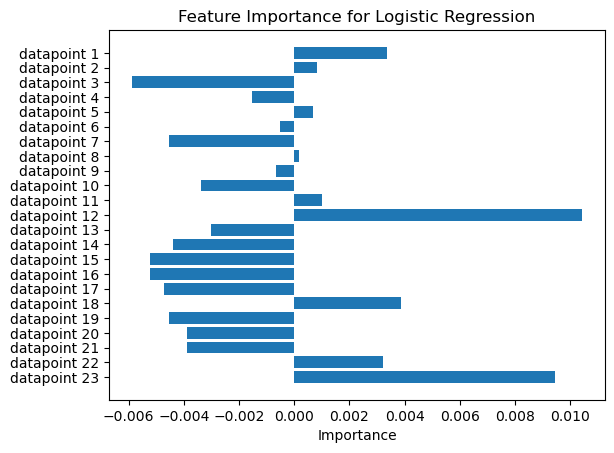

In [ ]:
result = permutation_importance(logreg, X, y, n_repeats=10, random_state=0)
importance = result.importances_mean
# Get feature names
feature_names = X.columns

# Create a bar chart
fig, ax = plt.subplots()
y_pos = np.arange(len(feature_names))
ax.barh(y_pos, importance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_title('Feature Importance for Logistic Regression')

plt.show()

Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Define the parameter grid for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a decision tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(dt_model, param_grid, scoring='f1', cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the GridSearchCV object
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Print the accuracy, precision, recall, and F1 score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Accuracy: 0.9243697478991597
Precision: 0.927639306996143
Recall: 0.9243697478991597
F1 score: 0.9243697478991597
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}


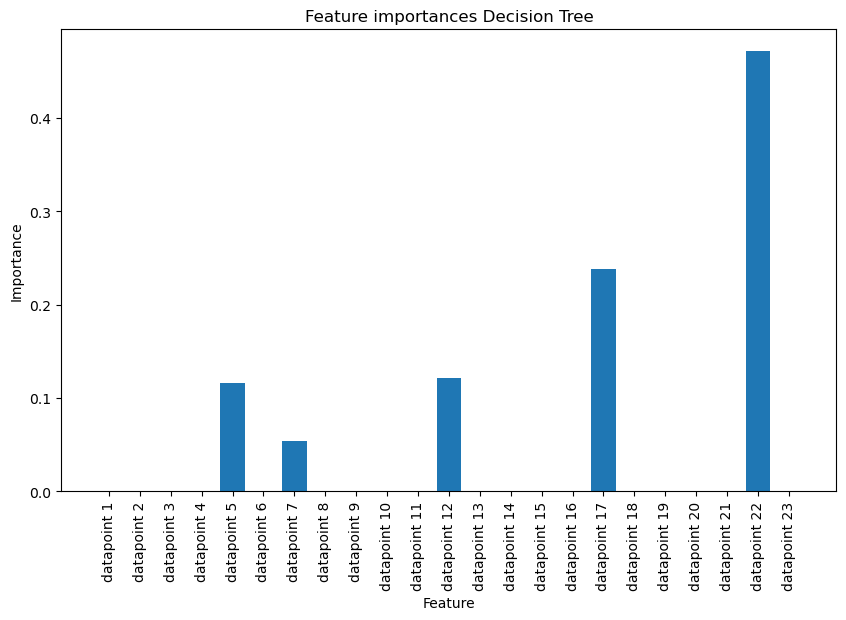

In [ ]:
# Get feature importances from the trained model
importances = dt_model.feature_importances_

# Get the feature names in the original order
feature_names = X_train.columns

# Plot the feature importances
plt.figure(figsize=(10,6))
plt.title("Feature importances Decision Tree")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90)
plt.show()

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(rfc, param_grid, scoring='f1', cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the GridSearchCV object
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Print the accuracy, precision, recall, and F1 score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Accuracy: 0.9495798319327731
Precision: 0.9495798319327731
Recall: 0.9495798319327731
F1 score: 0.9495798319327731
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


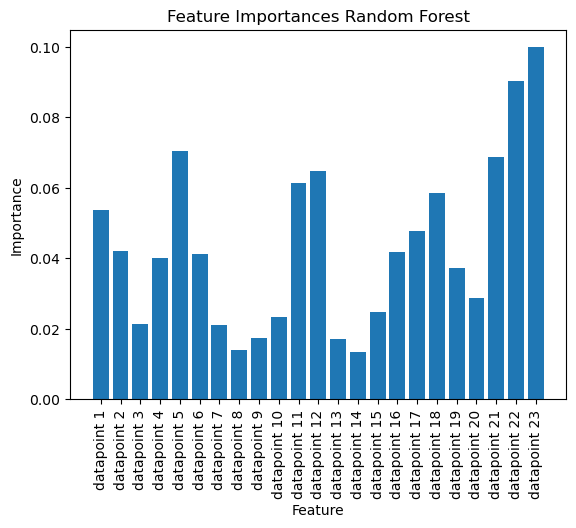

In [ ]:
importances = rfc.feature_importances_

# Create a bar chart of feature importances
plt.bar(range(X.shape[1]), importances)
plt.xticks(range(X.shape[1]), X_train.columns, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances Random Forest")
plt.show()

SVM

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

SVM = svm.LinearSVC()
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

Accuracy: 0.9243697478991597
Precision: 0.9344262295081968
Recall: 0.9193548387096774
F1 score: 0.9268292682926829


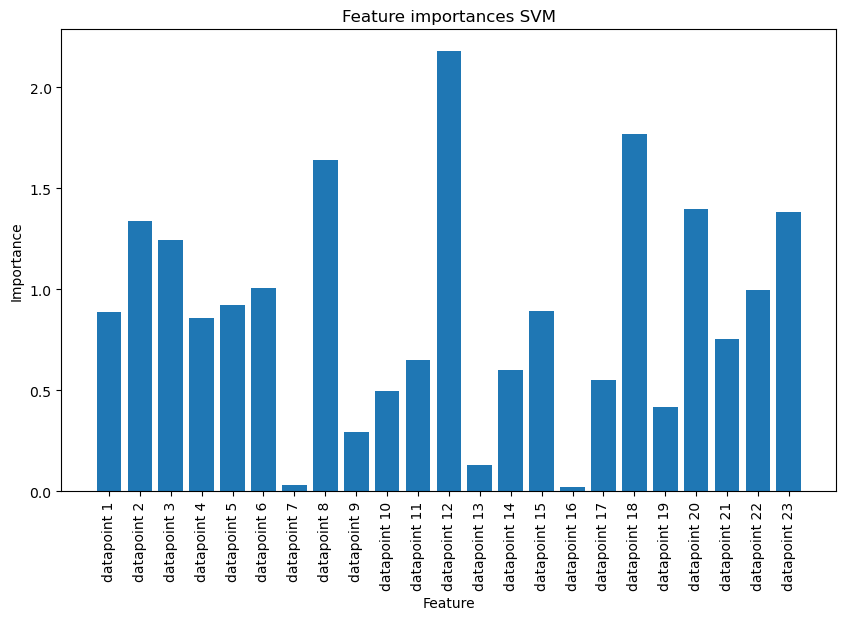

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances from the trained model
importances = np.abs(SVM.coef_[0])

# Get the feature names in the original order
feature_names = X_train.columns

# Plot the feature importances
plt.figure(figsize=(10,6))
plt.title("Feature importances SVM")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90)
plt.show()

XG Boost

In [ ]:
import xgboost as xgb

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, scoring='f1', cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the GridSearchCV object
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Print the accuracy, precision, recall, and F1 score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Accuracy: 0.9663865546218487
Precision: 0.9663865546218487
Recall: 0.9663865546218487
F1 score: 0.9663865546218487
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}


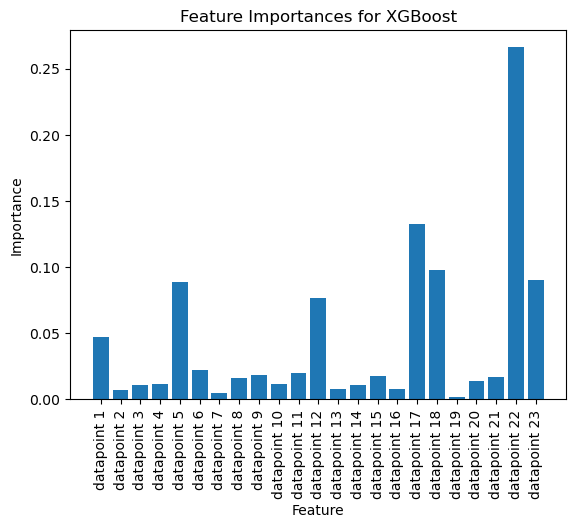

In [ ]:
importances = xgb_model.feature_importances_

# Print feature importances
    
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]), X.columns, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances for XGBoost")
plt.show()


LightGBM

In [ ]:
import lightgbm as lgb

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Create a LightGBM classifier
lgb_model = lgb.LGBMClassifier(random_state=42)

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(lgb_model, param_grid, scoring='f1', cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the GridSearchCV object
best_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Print the accuracy, precision, recall, and F1 score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

Accuracy: 0.9663865546218487
Precision: 0.9663865546218487
Recall: 0.9663865546218487
F1 score: 0.9663865546218487
Best hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}


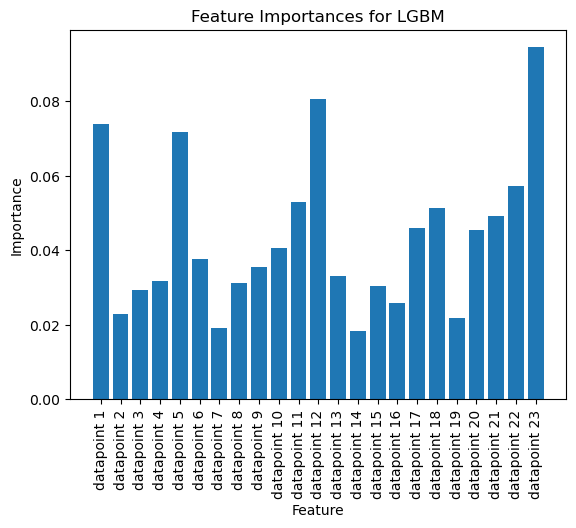

In [ ]:
# Get feature importances
importances = lgb_model.feature_importances_
importances_pct = (importances / importances.sum())

# Create a bar chart of feature importances
plt.bar(range(X.shape[1]), importances_pct)
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances for LGBM")
plt.show()

Simple Neural Network:

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense

input_size = 23

nn_model = Sequential()
nn_model.add(Dense(32, input_dim=input_size, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

2023-05-05 14:55:19.558653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
nn_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose = 0)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict the classes of the test set using the trained model
y_prob = nn_model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)


# Calculate the accuracy, recall, precision, and F1 score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the accuracy, recall, precision, and F1 score
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

4/4 [==============================] - 0s 957us/step
Accuracy: 0.957983193277311
Recall: 0.9516129032258065
Precision: 0.9672131147540983
F1 Score: 0.959349593495935


Recurrent Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Convert the data to numpy arrays
X_train_np = X_train.values
X_test_np = X_test.values

# Reshape the data
X_train_reshaped = X_train_np.reshape(X_train_np.shape[0], X_train_np.shape[1], 1)
X_test_reshaped = X_test_np.reshape(X_test_np.shape[0], X_test_np.shape[1], 1)

# Define the RNN model
rnn_model = Sequential()
rnn_model.add(LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
rnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
rnn_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose = 0)

# Evaluate the model on the test set
loss, accuracy = rnn_model.evaluate(X_test_reshaped, y_test)
print("Accuracy:", accuracy)



4/4 [==============================] - 0s 4ms/step - loss: 0.0987 - accuracy: 0.9664
Accuracy: 0.9663865566253662


In [ ]:
y_prob = rnn_model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)
# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

# Print the classification report
print(classification_report(y_test, y_pred))

# Calculate the accuracy, recall, precision, and F1 score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the accuracy, recall, precision, and F1 score
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)


4/4 [==============================] - 0s 3ms/step
[[56  1]
 [ 4 58]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        57
           1       0.98      0.94      0.96        62

    accuracy                           0.96       119
   macro avg       0.96      0.96      0.96       119
weighted avg       0.96      0.96      0.96       119

Accuracy: 0.957983193277311
Recall: 0.9354838709677419
Precision: 0.9830508474576272
F1 Score: 0.9586776859504132


In [ ]:
start_date = datetime.datetime(2021, 12, 1)
end_date = datetime.datetime(2022, 5, 1)
time_slice = f"{start_date.date().isoformat()}/{end_date.date().isoformat()}"
latlong = "(10.4391, 105.3338)"
RVI, VH, VV, dates = get_sentinel_data(latlong, time_slice)


# RVI rice and non-rice line graphs

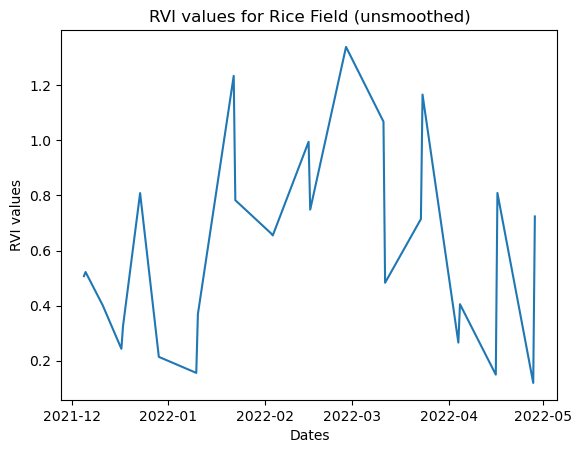

In [ ]:
# Create figure and plot
fig, ax = plt.subplots()
ax.plot(dates, RVI)

# Format the plot
ax.set_title('RVI values for Rice Field (unsmoothed)')
ax.set_xlabel('Dates')
ax.set_ylabel('RVI values')

# Show the plot
plt.show()

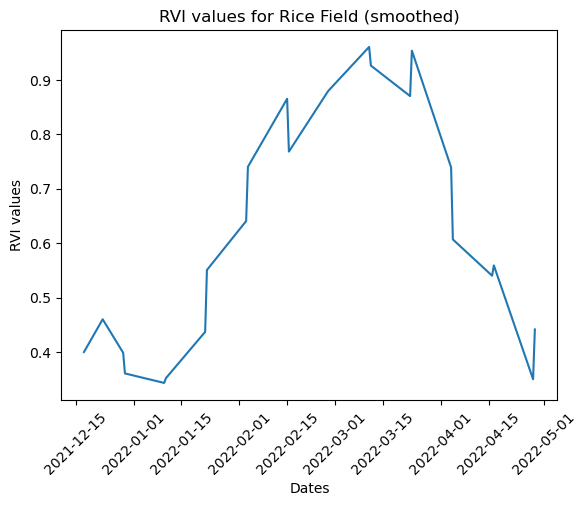

In [ ]:
RVI_smooth = np.convolve(RVI, np.ones(window_size)/window_size, mode='valid')
# Create figure and plot
fig, ax = plt.subplots()
ax.plot(dates[:23], RVI_smooth)

# Format the plot
ax.set_title('RVI values for Rice Field (smoothed)')
ax.set_xlabel('Dates')
ax.set_ylabel('RVI values')
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
latlong = "(10.4391, 105.3338)"
latlong = crop_presence_data_rvi["Latitude and Longitude"][400]
RVI, VH, VV, dates = get_sentinel_data(latlong, time_slice)

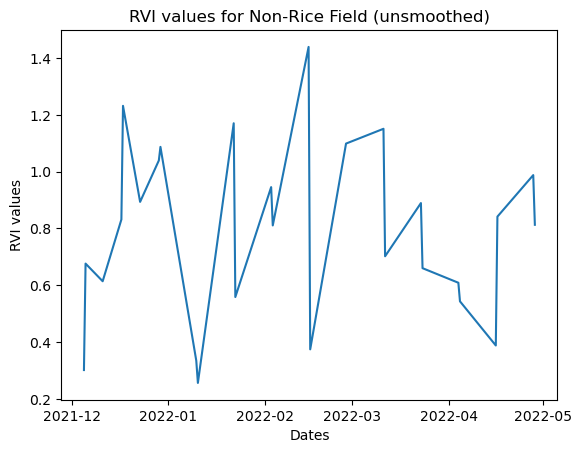

In [ ]:
# Create figure and plot
fig, ax = plt.subplots()
ax.plot(dates, RVI)

# Format the plot
ax.set_title('RVI values for Non-Rice Field (unsmoothed)')
ax.set_xlabel('Dates')
ax.set_ylabel('RVI values')

# Show the plot
plt.show()

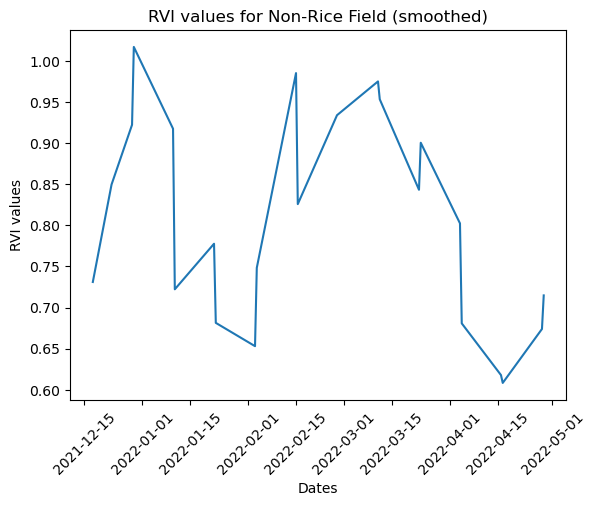

In [ ]:
RVI_smooth = np.convolve(RVI, np.ones(window_size)/window_size, mode='valid')
# Create figure and plot
fig, ax = plt.subplots()
ax.plot(dates[:23], RVI_smooth)

# Format the plot
ax.set_title('RVI values for Non-Rice Field (smoothed)')
ax.set_xlabel('Dates')
ax.set_ylabel('RVI values')
plt.xticks(rotation=45)

# Show the plot
plt.show()